In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Configuration Parameters

In [4]:
img_dim = 64          # Image resolution (64x64 pixels)
num_shapes = 5        # Number of shapes in each frame
seq_len = 10          # Number of frames in each sequence
num_samples = 5000    # Number of sequences to generate
shape_dim = 8         # Shape dimension (8x8 pixels)

In [5]:
# Function to create a single frame with randomly placed objects
def create_frame(direction=None, num_shapes=5, img_dim=64, shape_dim=8):
    frame = Image.new('RGB', (img_dim, img_dim), color='white')
    drawer = ImageDraw.Draw(frame)
    
    objects = []
    for _ in range(num_shapes):
        x, y = random.randint(0, img_dim - shape_dim), random.randint(0, img_dim - shape_dim)
        drawer.rectangle((x, y, x + shape_dim, y + shape_dim), fill="black")
        if direction:
            objects.append((x, y, direction))  # Save initial position and movement direction
    return np.array(frame), objects

# Function to create a sequence of frames with movement
def create_sequence(move_together=True, seq_len=10, img_dim=64, shape_dim=8):
    sequence = []
    shapes = []
    initial_frame, initial_objects = create_frame(num_shapes=num_shapes)
    sequence.append(initial_frame)
    
    # Define direction for each shape
    for obj in initial_objects:
        direction = random.choice(["up", "down", "left", "right"]) if not move_together else "right"
        shapes.append((*obj[:2], direction))
    
    # Create frames based on the initial direction
    for _ in range(seq_len - 1):
        frame = Image.new('RGB', (img_dim, img_dim), color='white')
        drawer = ImageDraw.Draw(frame)
        updated_shapes = []
        
        for obj in shapes:
            x, y, direction = obj
            if direction == "right":
                x = min(x + shape_dim, img_dim - shape_dim)
            elif direction == "left":
                x = max(x - shape_dim, 0)
            elif direction == "up":
                y = max(y - shape_dim, 0)
            elif direction == "down":
                y = min(y + shape_dim, img_dim - shape_dim)
            
            drawer.rectangle((x, y, x + shape_dim, y + shape_dim), fill="black")
            updated_shapes.append((x, y, direction))
        
        sequence.append(np.array(frame))
        shapes = updated_shapes
    
    return np.array(sequence), int(move_together)

# Generate the dataset with frames and sequences
def build_dataset(num_samples=5000, seq_len=10):
    data_X, data_y = [], []
    for _ in range(num_samples):
        move_together = random.choice([True, False])
        sequence, label = create_sequence(move_together=move_together, seq_len=seq_len)
        data_X.append(sequence)
        data_y.append(label)
    
    data_X = np.array(data_X)
    data_y = np.array(data_y)
    return data_X, data_y


In [6]:
# Create and normalize the dataset
X, y = build_dataset(num_samples=num_samples, seq_len=seq_len)
X = X / 255.0

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define a CNN-LSTM model for the sequence data

In [7]:
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    model.add(layers.LSTM(128))  # Increased LSTM units for learning complex patterns
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Another dropout layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    
    return model


In [8]:
# Compile the model
input_shape = (seq_len, img_dim, img_dim, 3)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


e:\MTech Courses\CS786 Cognitive\Assignments\Assignment 3\.venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.4936 - loss: 0.7532 - val_accuracy: 0.5200 - val_loss: 0.6924
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.4660 - loss: 0.7080 - val_accuracy: 0.5200 - val_loss: 0.6928
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5108 - loss: 0.6954 - val_accuracy: 0.4800 - val_loss: 0.6995
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5092 - loss: 0.6972 - val_accuracy: 0.4800 - val_loss: 0.6942
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4967 - loss: 0.6947 - val_accuracy: 0.4800 - val_loss: 0.6934
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.4884 - loss: 0.6946 - val_accuracy: 0.5200 - val_loss: 0.6931
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5212 - loss: 0.6932 - val_accuracy: 0.5200 - val_loss: 0.6928
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.5090 - loss: 0.6931 - val_accu

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step


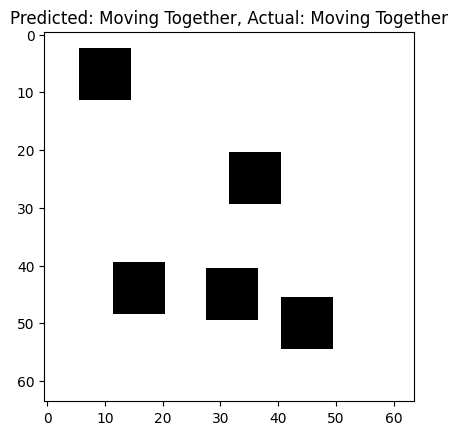

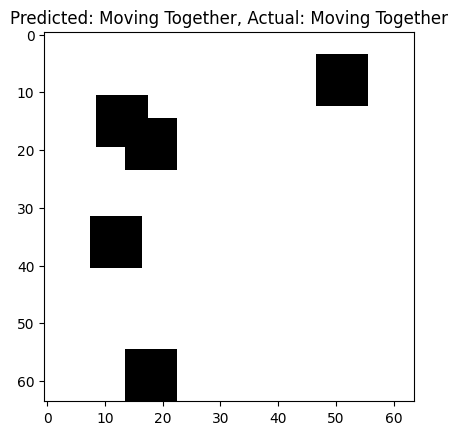

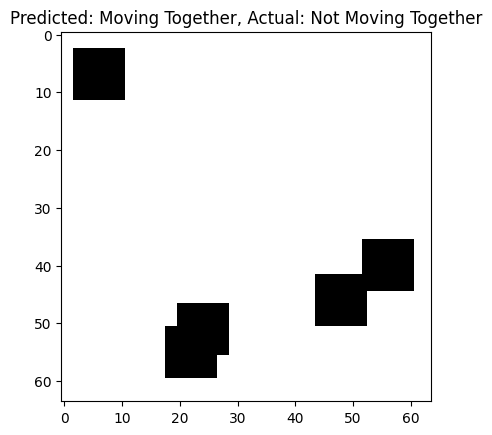

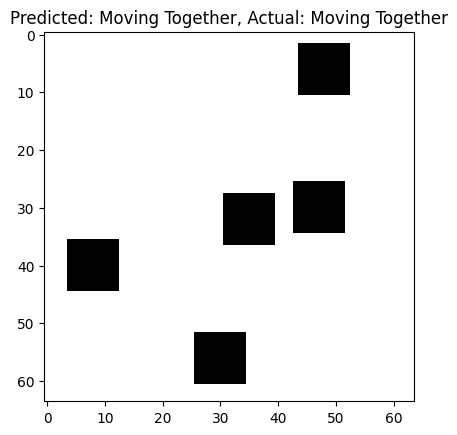

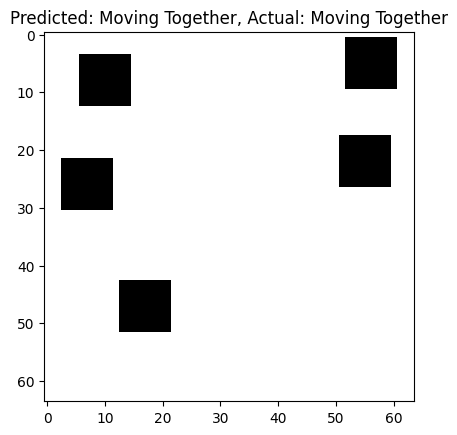

In [9]:
# Function to display model predictions
def display_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    for i in range(5):  # Display first 5 predictions
        plt.imshow(X_test[i][0])  # Display the first frame of the sequence
        predicted_label = "Moving Together" if predictions[i] > 0.5 else "Not Moving Together"
        actual_label = "Moving Together" if y_test[i] == 1 else "Not Moving Together"
        plt.title(f'Predicted: {predicted_label}, Actual: {actual_label}')
        plt.show()

# Show some example predictions
display_predictions(model, X_test, y_test)
